In [1]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import xgboost as xgb
import seaborn as sns
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from termcolor import colored
from cudf_workaround import cudf_groupby_aggs
import matplotlib.pyplot as plt
import os
import time
import warnings
warnings.filterwarnings("ignore")
sns.set()

**This is a 2 minutes end-to-end gpu-only demos the 8th place solution (8/1094) of Rapids.ai for the __[PLAsTiCC Astronomical Classification](https://www.kaggle.com/c/PLAsTiCC-2018/leaderboard)__.** 

## Table of contents
[1. Global variables](#global)<br>
[2. Functions](#func)<br>
[3. ETL & Visualizations](#etl)<br>
[4. Model training](#train)<br>
[5. Conclusions](#conclusions)

<a id="global"></a>
## 1. Global variables 

**Original data download and description __[link](https://www.kaggle.com/c/PLAsTiCC-2018/data)__**.

In [2]:
PATH = '../data'

**Tested on V100 with 32 GB GPU memory. Please reset this variable if memory capacity is smaller, and the input data will be down sampled accordingly.**

In [3]:
GPU_MEMORY = 32 # GB. 

In [4]:
TEST_ROWS = 453653104 # number of rows in test data
# no skip if your gpu has 32 GB memory
# otherwise, skip rows porportionally
SKIP_ROWS = int((1 - GPU_MEMORY/32.0)*TEST_ROWS) 
GPU_RUN_TIME = {}

In [5]:
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

<a id="func"></a>
## 2. Functions

In [6]:
def scatter(x,y,values,xlabel='x',ylabel='y',title=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    colors = np.array([colors[i] for i in values])
    ps = []
    bs = []
    bands = ['passband_%s'%i for i in ['u', 'g', 'r', 'i', 'z','y']]
    for i in sorted(np.unique(values)):
        mask = values==i
        if len(x[mask]):
            p = plt.scatter(x[mask],y[mask],c=colors[mask])
            ps.append(p)
            bs.append(bands[i])
    plt.legend(ps,bs,scatterpoints=1)
    if title is not None:
        plt.title(title)
    
    plt.xlim([np.min(x)-10,np.min(x)+1500])
    plt.ylabel('y: %s'%ylabel)
    plt.xlabel('x: %s'%xlabel)

In [7]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    """
    refactor from
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def xgb_multi_weighted_logloss(y_predicted, y_true, classes, class_weights):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted, 
                                  classes, class_weights)
    return 'wloss', loss

### GPU ETL functions 

In [8]:
# To save GPU memory, we drop the column as soon as it is done with groupby
# this hits performance a little but avoids GPU OOM.
def groupby_aggs(df,aggs,col):
    res = None
    for i,j in aggs.items():
        for k in j:
            #print(i,k)
            tmp = df.groupby(col).agg({i:[k]})
            if res is None:
                res = tmp
            else:
                res = res.merge(tmp,on=[col],how='left')
        df.drop_column(i)
    return res

def etl_gpu(df,df_meta):
    aggs = {
        'passband': ['mean'], 
        'detected': ['mean'],
        'mjd':['max','min'],
    }
    agg_df = groupby_aggs(df,aggs,'object_id')
    # at this step, columns ['passband','detected','mjd'] are deleted 
    
    df['flux_ratio_sq'] = df['flux'] / df['flux_err']
    df['flux_ratio_sq'] = df['flux_ratio_sq'].applymap(lambda x: math.pow(x,2))
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs2 = {
        'flux_ratio_sq':['sum'],
        'flux_by_flux_ratio_sq':['sum'],
        'flux': ['min', 'max', 'mean'],
        'flux_err': ['min', 'max', 'mean'],
    }
    agg_df2 = groupby_aggs(df,aggs2,'object_id')
    agg_df = agg_df.merge(agg_df2,on=['object_id'],how='left')
    del agg_df2

    agg_df['flux_diff'] = agg_df['max_flux'] - agg_df['min_flux']
    agg_df['flux_dif2'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['mean_flux']
    agg_df['flux_w_mean'] = agg_df['sum_flux_by_flux_ratio_sq'] / agg_df['sum_flux_ratio_sq']
    agg_df['flux_dif3'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['max_mjd'] - agg_df['min_mjd']
    agg_df.drop_column('max_mjd')
    agg_df.drop_column('min_mjd')
    
    for col in ['ra','decl','gal_l','gal_b']:
        df_meta.drop_column(col)
    
    df_meta = df_meta.merge(agg_df,on=['object_id'],how='left')
    return df_meta

<a id="etl"></a>
## 3. ETL & Visualizations

### Load data for ETL part 1
**GPU load data**

In [9]:
%%time
start = time.time()
step = 'load data part1'
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)
test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 13.4 s, sys: 6.66 s, total: 20.1 s
Wall time: 20.7 s


### Visualizations

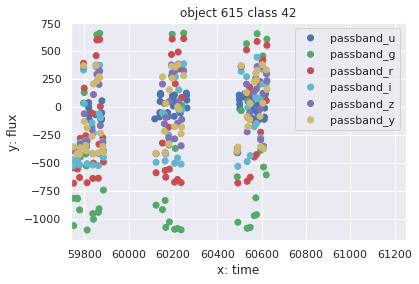

In [10]:
oid = 615
train = train_gd.to_pandas()
mask = train.object_id== oid
scatter(train.loc[mask,'mjd'].values,
                train.loc[mask,'flux'].values,
                values=train.loc[mask,'passband'].values,
                xlabel='time',ylabel='flux',title='object %d class 42'%oid)

### ETL part 1 with 100x  speedup

In [11]:
%%time
# to save memory, we need to move dataframe to cpu and only keep the columns we need
test_gd = test_gd[['object_id','flux']]
train_gd = train_gd[['object_id','flux']]

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 9.96 ms


In [12]:
%%time
# GPU
step = 'ETL part1'
start = time.time()
aggs = {'flux':['skew']}
test_gd = cudf_groupby_aggs(test_gd,group_id_col='object_id',aggs=aggs)
train_gd = cudf_groupby_aggs(train_gd,group_id_col='object_id',aggs=aggs)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 3.64 s, sys: 948 ms, total: 4.59 s
Wall time: 5.1 s


In [13]:
%%time
test_gd = test_gd.sort_values(by='object_id')
train_gd = train_gd.sort_values(by='object_id')
# Rename the variables
test_flux_skew_gd = test_gd
train_flux_skew_gd = train_gd

CPU times: user 20 ms, sys: 20 ms, total: 40 ms
Wall time: 40 ms


### Load data for the ETL part 2 with 11x speedup

In [14]:
%%time
# read data on gpu
step = 'load data part2'
start = time.time()
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header
train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)

cols = ['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf',
       'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 
       'distmod','mwebv', 'target']
dtypes = ['int32']+['float32']*4+['int32']+['float32']*5+['int32']

train_meta_gd = gd.read_csv('%s/training_set_metadata.csv'%PATH,
            names=cols,dtype=dtypes,skiprows=1)
del cols[-1],dtypes[-1]
test_meta_gd = gd.read_csv('%s/test_set_metadata.csv'%PATH,
            names=cols,dtype=dtypes,skiprows=1)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 13.8 s, sys: 6.45 s, total: 20.3 s
Wall time: 20.6 s


### ETL part2 with 9x ~ 12x speedup 

In [15]:
%%time
# GPU
start = time.time()
step = 'ETL part2'
train_final_gd = etl_gpu(train_gd,train_meta_gd)
train_final_gd = train_final_gd.merge(train_flux_skew_gd,on=['object_id'],how='left')
test_final_gd = etl_gpu(test_gd,test_meta_gd)
del test_gd,test_meta_gd
test_final_gd = test_final_gd.merge(test_flux_skew_gd,on=['object_id'],how='left')
GPU_RUN_TIME[step] = time.time() - start

1:int32
2:int32
3:int32
1:int32
1:int32
2:int32
3:float32
1:int32
1:int32
1:float32
2:int32
3:float32
1:float32
2:int32
3:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:float32
1:float32
1:float32
1:float32
1:float32
1:float32
1:float32
2:int32
3:float32
1:int32
1:int32
1:float32
1:float32
2:int32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
1:int32
1:float32
1:float32
1:float32
1:float32
1:float32
1:int32
2:int32
3:int32
3:int32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
3:float32
1:int32
1:float32
1:float32
1:float32
1:float32
1:float32
1:int32
1:int32
1:int32
1:float32
1:float32
1:float32
1:float32
1:float32
1:float32
1:floa

<a id="train"></a>
## 4. Model training

### train and validation with 5x speedup

In [16]:
y = train_final_gd['target'].to_array()
classes = sorted(np.unique(y))    
# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weights = {c: 1 for c in classes}
class_weights.update({c:2 for c in [64, 15]})

lbl = LabelEncoder()
y = lbl.fit_transform(y)

cols = [i for i in test_final_gd.columns if i not in ['object_id','target']]
for col in cols:
    train_final_gd[col] = train_final_gd[col].fillna(0).astype('float32')

for col in cols:
    test_final_gd[col] = test_final_gd[col].fillna(0).astype('float32')
    
X = train_final_gd[cols].as_matrix()
Xt = test_final_gd[cols].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y)

In [17]:
cpu_params = {
            'objective': 'multi:softprob', 
            'tree_method': 'hist', 
            'nthread': 16, 
            'num_class':14,
            'max_depth': 7, 
            'silent':1,
            'subsample':0.7,
            'colsample_bytree': 0.7,}

In [18]:
func_loss = partial(xgb_multi_weighted_logloss, 
                        classes=classes, 
                        class_weights=class_weights)

In [19]:
# GPU
gpu_params = cpu_params.copy()
gpu_params.update({'objective': 'multi:softprob',
                   'tree_method': 'gpu_hist', 
                  })

In [20]:
%%time
step = 'training'
start = time.time()
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
clf = xgb.train(gpu_params, dtrain=dtrain,
                num_boost_round=60,evals=watchlist,
                feval=func_loss,early_stopping_rounds=10,
                verbose_eval=1000)
yp = clf.predict(dvalid)
gpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)
ysub = clf.predict(dtest)
line = 'validation loss %.4f'%gpu_loss
print(colored(line,'green'))
GPU_RUN_TIME[step] = time.time() - start

[0]	eval-merror:0.369427	train-merror:0.299589	eval-wloss:2.0015	train-wloss:1.91265
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.304459	train-merror:0.002265	eval-wloss:1.29726	train-wloss:0.099663
validation loss 1.2973
CPU times: user 1min 14s, sys: 1.33 s, total: 1min 16s
Wall time: 6.31 s


<a id="conclusions"></a>
## 5. Conclustions

In [21]:
GPU_RUN_TIME

{'load data part1': 20.68454670906067,
 'ETL part1': 5.097989559173584,
 'load data part2': 20.622219800949097,
 'ETL part2': 12.378713846206665,
 'training': 6.307511329650879}

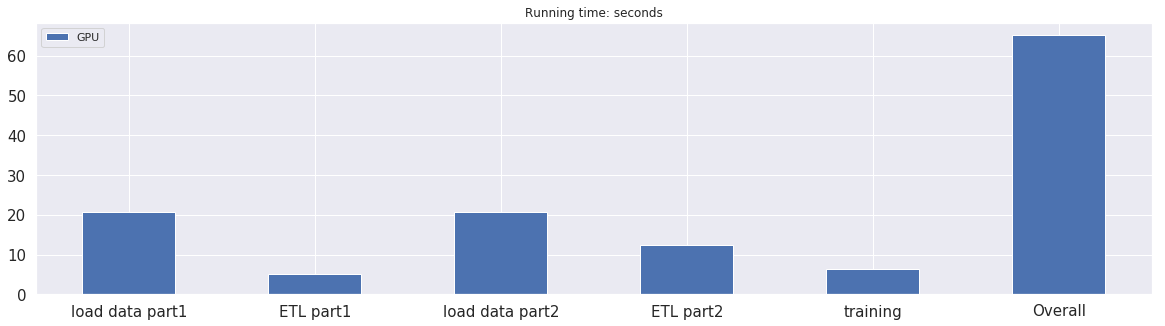

In [22]:
steps = ['load data part1','ETL part1','load data part2','ETL part2','training']
GPU_RUN_TIME['Overall'] = sum([GPU_RUN_TIME[i] for i in steps])
steps.append('Overall')
gpu_time = [GPU_RUN_TIME[i] for i in steps]
df = pd.DataFrame({'GPU': gpu_time}, index=steps)
df.plot.bar(rot=0,figsize=(20,5), fontsize=15, title='Running time: seconds')